In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.special import expit
from scipy.optimize import minimize_scalar

import copy

from numpy.linalg import pinv
from sklearn.datasets import load_iris
from scipy.optimize import fmin_bfgs

import multiprocessing as mp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

In [3]:
'''
Here, the val function gives the value of the activation, and the dev is the derivative value of the activation.
'''
class Linear:
    def val(x):
        return x
    def dev(x):
        return 1

class TANH:
    def val(x):
        return np.tanh(x)
    def dev(x):
        return 1 - np.tanh(x)*np.tanh(x)

class Sigmoid:
    def val(x):
        return 1 / (1 + np.exp(-x))
    def dev(x):
        return (1 / (1 + np.exp(-x))) * (1-1 / (1 + np.exp(-x)))

class Relu:    
    def val(x):
        return np.maximum(x.copy(),0)
    def dev(x):
        return (x>0).astype(int)

class ArcTan:    
    def val(x):
        return np.arctan(x)
    def dev(x):
        return 1/(x*x+1)
    
class SiLU:
    def val(x):
        return x / (1 + np.exp(-x))
    def dev(x):
        return x / (1 + np.exp(-x)) + (1-x / (1 + np.exp(-x))) / (1 + np.exp(-x))

'''
Here, we define the three different adaptive learning rates.
'''
def no_decay(eta,t,epoch):
    return eta

def exp_decay(eta,t,epoch):
    k = 0.001
    lrate = eta * np.exp(-k*t)
    return lrate

def inverse_decay(eta,t,epoch):
    lrate = eta /(1+t/epoch)
    return lrate

So, we can write the cost function in the following fashion.
\begin{equation*}
cost\_ function = f_i(\phi_{i} (M_i \phi_{i-1}(M_{i-1} N_{i-2}+b_{i-1}) + b_i))
\end{equation*}
in which, $f_i$ represents all the afterward layers and the cost function definition, $b_i$ is the bias term for the $i$-th layer, and $N_i$ is the neuron value of the $i$-th layer, $V_i$ is the value before apply the activation function($V_i = M_{i} N_{i-1}+b_{i}$). 

We find that:
\begin{equation*}
\frac{\partial (cost\_ function)}{\partial M_i} = f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)* N_{i-1}
\end{equation*}
\begin{equation*}
\frac{\partial (cost\_ function)}{\partial b_i} = f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)
\end{equation*}
\begin{equation*}
\frac{\partial (cost\_ function)}{\partial M_{i-1}} = f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)* M_{i}*\phi_{i-1}^{'}(V_{i-1})*N_{i-2}
\end{equation*}
\begin{equation*}
\frac{\partial (cost\_ function)}{\partial b_{i-1}} = f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)* M_{i}*\phi_{i-1}^{'}(V_{i-1})
\end{equation*}
In principle we can also write the third equation as,
\begin{equation*}
\frac{\partial (cost\_ function)}{\partial M_{i-1}} = f_{i-1} ^{'}(N_{i-1})*\phi_{i-1}^{'}(V_{i-1})*N_{i-2}
\end{equation*}
which gives us that
\begin{equation*}
 f_{i-1} ^{'}(N_{i-1})= f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)* M_{i}
\end{equation*}
We can refer $f_i ^{'}(N_{i})$ as the derivative_prefix, and as long as we can keep track of the derivative_prefix in different layers, we can calculate the partial derivative of each layer efficiently.

Note that, in the formulas above, we only show the ingredients of every equation for the purpose of simplicity, in the actual formula, we need to move the matrice around and use different multiplications carefully.

The actual iterations are as follow:
\begin{equation*} 
 f_{i-1} ^{'}(N_{i-1})=  M_{i}^T@f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)
\end{equation*}
\begin{equation*}
\frac{\partial (cost\_ function)}{\partial M_i} = f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)@ N_{i-1}^T
\end{equation*}
\begin{equation*}
\frac{\partial (cost\_ function)}{\partial b_i} = f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i) @ I
\end{equation*}
In the last formula, $I$ is a matrix with value 1.


We start with the last layer, and the initial derivative_prefix is the derivative of the cost_fuction (either mean square error or cross entropy).

In [39]:
class Sequential(object):
    def __init__(self, C=0.0, epochs=500, eta=0.001, random_state=None, 
                 cost_function='quadratic', 
                 metric='accuracy',
                 verbose=1,
                 regular='None',
                 learning_rate = no_decay,
                 early_stopping=False):
        np.random.seed(random_state)
        self.C = C
        self.epochs = epochs
        self.eta = eta
        self.cost_function = cost_function
        self.metric = metric
        self.verbose = verbose
        self.regular = regular
        self.early_stopping = early_stopping
        self.learning_rate = learning_rate
        
        self.dims = []
        self.acts = []
        
        self.matrice = []
        self.bias = []
        self.vects = [] #before the activation function
        self.neurons = [] #after the activation function
        self.dropout = [] #to be implemented later
        self.Y = []
        
        self.loss = []
        self.grad_norm = []
        
    def add(self,arg,argv):
        '''
        add('Dense',12)
        add('Dense',15)
        add('Activation',Sigmoid)
        add('Activation',Relu)
        add('Dropout',0.5)
        '''
        if arg == 'Dense':
            if len(self.dropout) < len(self.dims):
                self.dropout.append(0)
            if len(self.dims) == 0:
                self.dims.append([0,argv])
            else:
                self.dims.append([self.dims[-1][-1],argv])
                
            self.grad_norm.append([]) #keep track of the grad_norm
        if arg == 'Activation':
            self.acts.append(argv)
        if arg == 'Dropout':
            self.dropout.append(argv)
        return
    
    @staticmethod
    def _encode_labels(y):
        onehot = pd.get_dummies(y).values.T
        return onehot

    def _initialize_params(self,X,Y):
        for row,col in self.dims:
            W_num_elems = row*col
            W = np.random.uniform(-1.0, 1.0, size=W_num_elems)
            W = W.reshape(col, row) # reshape to be W
            self.matrice.append(W)
            
            b = np.random.uniform(-1.0, 1.0, size=col)
            b = b.reshape(col, 1)
            self.bias.append(b) #adding bias vector
        
        self.neurons.append(X.T)
        self.Y = self._encode_labels(Y)
        return
    
    def activate(self,vec,act):
        return act.val(vec)
    
    def activate_dev(self,vec,act):
        return act.dev(vec)
    
    def _feedforward(self):
        '''
        clear the previous feedforward result
        '''
        self.neurons = self.neurons[:1]
        self.vects = []
        for W,b,act in zip(self.matrice,self.bias,self.acts):
            self.vects.append(W @ self.neurons[-1] + b)
            self.neurons.append(self.activate(self.vects[-1],act))
        m = self.Y.shape[1]
        if self.cost_function == 'quadratic':
            self.loss.append(((self.neurons[-1]-self.Y)*(self.neurons[-1]-self.Y)).sum()/m)
        elif self.cost_function == 'cross_entropy':
            cost = -(1.0/m) * np.sum(self.Y*np.log(self.neurons[-1]) + (1-self.Y)*np.log(1-self.neurons[-1]))
            self.loss.append(cost)
        return

    def predict(self,X_test):
        neuron = X_test.T
        for W,b,act in zip(self.matrice,self.bias,self.acts):
            vec = W @ neuron + b
            neuron = self.activate(vec,act)
        y_pred = np.argmax(neuron, axis=0)
        return y_pred

    def set_init_dev_prefix(self):
        if self.cost_function == 'quadratic':
            return -2 * (self.Y - self.neurons[-1])
        if self.cost_function == 'cross_entropy':
            return -(self.Y-self.neurons[-1])

    def _update_params(self):
        cur_dev_prefix = self.set_init_dev_prefix()
        grads = []
        bias_grads = []
        for N,N1,V,act,W in zip(self.neurons[1:][::-1],self.neurons[:-1][::-1],self.vects[::-1],self.acts[::-1],self.matrice[::-1]):
            cur_dev_prefix *= self.activate_dev(V,act)
            grads.append(cur_dev_prefix @ N1.T)
            bias_grads.append(cur_dev_prefix @ np.full((cur_dev_prefix.shape[1], 1), 1))
            cur_dev_prefix = W.T @ cur_dev_prefix
        grads.reverse()
        bias_grads.reverse()
        
        if self.regular != 'None':
            for W,b,grad,bias_grad in zip(self.matrice,self.bias,grads,bias_grads):
                if 'L2' in self.regular:
                    grad += 2*self.C * W
                    bias_grad += 2*self.C * b
                if 'L1' in self.regular:
                    grad += ((W>0).astype(int)-0.5)*(2*self.C)
                    bias_grad += self.C *((b>0).astype(int)-0.5)*(2*self.C)
                    
        for W,grad,b,bias_grad,grad_n in zip(self.matrice,grads,self.bias,bias_grads,self.grad_norm):
            W -= self.eta * grad
            b -= self.eta * bias_grad
            
            grad_n.append(max(grad.max(),b.max()))#keep track of the grad norm
        return
    
    def fit(self,X,Y):
        self.dims[0][0] = X.shape[1]
        if len(np.unique(Y)) != self.dims[-1][-1]:
            print('Error: output dimension is wrong!')
            return False
        self._initialize_params(X,Y)
        eta_0 = self.eta

        for i in range(self.epochs):
            self.eta = self.learning_rate(eta_0,i,self.epochs)
            self._feedforward()
            self._update_params()

            if self.verbose and not i % max(1,int(self.epochs/10)):
                if self.metric == 'accuracy':
                    accu = accuracy_score(np.argmax(self.neurons[-1], axis=0),Y)
                    meas = 'accuracy'
                if self.metric == 'customized':
                    accu = cost_metric(Y,np.argmax(self.neurons[-1], axis=0),my_cost_matrix)
                    meas = 'customized cost'
                print('{} percent finished, current {} is {:.3f}.'.format(100*i//self.epochs,meas,accu))
        if self.verbose:
            print('Training is done!')
        return
    
    def plot(self):
        plt.figure()
        plt.plot([i for i in range(self.epochs-100)],self.loss[100:])
        plt.xlabel('Epoch number')
        plt.ylabel('Loss')
        plt.show()
        return
    def grad_plot(self):
        self.grad_norm = [np.array(arr)/self.Y.shape[1] for arr in self.grad_norm]
        ax = plt.subplot(1,1,1)
        for idx,arr in enumerate(self.grad_norm):
            plt.plot(abs(arr[100:]), label='w'+str(idx))
        plt.legend()
        plt.ylabel('Average gradient magnitude')
        plt.xlabel('Iteration')
        plt.show()
        return

Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/hpc/applications/anaconda/3/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/hpc/applications/anaconda/3/lib/python3.6/multiprocessing/pool.py", line 597, in _terminate_pool
    cls._help_stuff_finish(inqueue, task_handler, len(pool))
  File "/hpc/applications/anaconda/3/lib/python3.6/multiprocessing/pool.py", line 582, in _help_stuff_finish
    inqueue._rlock.acquire()
KeyboardInterrupt


In [5]:
full_df = pd.read_csv('data/processed_data.csv')

Y = full_df['readmitted'].replace({'NO':0,'<30':1,'>30':2}).values
data_cols = list(full_df)
data_cols.remove('readmitted')
X = full_df[data_cols].values

In [6]:
if False:
    model = Sequential(C=0.001, epochs=2000, eta=0.00001, random_state=42, 
                     cost_function='cross_entropy', 
                     metric='accuracy',
                     verbose=1,
                     regular='L1',
                     learning_rate=no_decay)

    model.add('Dense',20)
    model.add('Activation',Relu)
    model.add('Dense',3)
    model.add('Activation',Sigmoid)



    model.fit(X,Y)

In [7]:
def find_cost_metric(y_true, y_pred, cost_matrix):
    conf_matrix = confusion_matrix(y_true, y_pred)
    if cost_matrix is None:
        # check if the user passed a cost matrix
        print('No cost matrix passed, using ones')
        cost_matrix = np.ones(conf_matrix.shape)
    if (cost_matrix < 0).all():
        # make sure they are all positive
        cost_matrix = cost_matrix - np.min(cost_matrix)
    cost_matrix = cost_matrix/len(y_true) # normalize for bounds       
    return(np.sum(conf_matrix * cost_matrix))

my_cost_matrix = np.array([[1,  10, 10],
                           [5,  0,  3],
                           [5,  3,  0]])

In [18]:
'''
modify the model to apply the grid search
'''

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

def estimator(param):
    model = Sequential(C=0, epochs=1000, eta=0.00001, random_state=42, 
                 cost_function=param['cost_function'], 
                 metric='accuracy',
                 verbose=0,
                 regular='None',
                 learning_rate=no_decay)
    for neu_nbr, act in zip(param['Layers'],param['Activations']):
        model.add('Dense',neu_nbr)
        model.add('Activation',act)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    acc = find_cost_metric(y_test,y_pred,my_cost_matrix)
    return acc

In [19]:
'''
create grid search parameters, in total testing 72 sets of parameters 
'''

import random
param_test = []
activation_list = [Linear,TANH,Sigmoid,Relu,ArcTan,SiLU]*5
for cost_function in ['cross_entropy','quadratic']:
    for layer_nbr in range(2,8,1):
        for k in range(6):
            #for same objective function and nbr of layers, create 6 sets of parameters
            neuron_list = [20 for i in range(layer_nbr-1)] + [3]
            #neuron number of hidden layers vary from 5 to 40
            random.shuffle(activation_list)
            act_list = activation_list[:layer_nbr-1] + [Sigmoid]
            #activation function of hidden layers are randomly selected
            tmp_param = {'cost_function':cost_function,'Layers':neuron_list,'Activations':act_list}
            param_test.append(tmp_param)

In [20]:
import multiprocessing as mp
n_core = mp.cpu_count()
print(n_core)

36


In [ ]:
'''
use multi-processing for the grid search
'''
pool = mp.Pool(processes=n_core)
cost_list = pool.map(estimator,param_test)
print(cost_list)

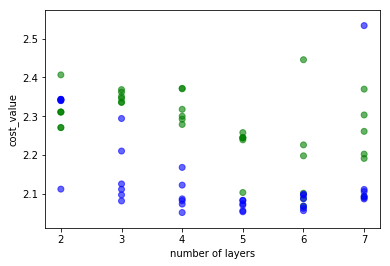

In [16]:
x_axis = [len(param_set['Layers']) for param_set in param_test]
y_axis = cost_list
c = ['blue' if param_set['cost_function']=='quadratic' else 'green' for param_set in param_test]
plt.scatter(x_axis, y_axis, alpha=0.6,c=c)
plt.xlabel('number of layers')
plt.ylabel('cost_value')
plt.show()

From the above graph, we notice two things:

1. Since the cost_value defined is roughly negatively propotional to the accuracy, it shows that the mean square error is much better than the cross entropy as the objective function overall.

2. As we increase the number of layers, the accuracy first increases, then start decreasing, and reaches maximum when it's 4 layers. I did another gird search where the number of neorons in each layer is a random number between 5 to 40, it also shows that when the number of layers is 4 gives the best accuracy.

Note that, in the search above we didnt exploit all possible combinations of activiation functions, we will run another analysis below. But lets check what is the best set of parameters we found so far.

In [17]:
best_param_idx = sorted(list(enumerate(cost_list)),key=lambda l:l[1])[0][0]
best_param = param_test[best_param_idx]
best_param

{'cost_function': 'quadratic',
 'Layers': [20, 20, 20, 3],
 'Activations': [__main__.Linear,
  __main__.SiLU,
  __main__.TANH,
  __main__.Sigmoid]}

Since Relu and SiLU are similar, and TANH, Sigmoid, ArcTan are similar, we will just replace the activation function of the second layer and third layer, and leave the rest untouched.

In [26]:
param_test = []
for act1 in [Relu,SiLU]:
    for act2 in [TANH,Sigmoid,ArcTan]:
        neuron_list = [20 for i in range(3)] + [3]
        act_list = [Linear,act1,act2,Sigmoid]
        tmp_param = {'cost_function':'quadratic','Layers':neuron_list,'Activations':act_list}
        param_test.append(tmp_param)

In [27]:
pool = mp.Pool(processes=6)
cost_list = pool.map(estimator,param_test)
print(cost_list)

[2.0616671021688004, 2.0475568330284815, 2.026286908805853, 2.0519989547948785, 2.0445779984321923, 2.029161222889992]


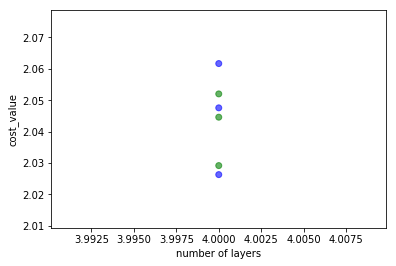

In [28]:
x_axis = [len(param_set['Layers']) for param_set in param_test]
y_axis = cost_list
c = ['blue' if param_set['Activations'][1]==Relu else 'green' for param_set in param_test]
plt.scatter(x_axis, y_axis, alpha=0.6,c=c)
plt.xlabel('number of layers')
plt.ylabel('cost_value')
plt.show()

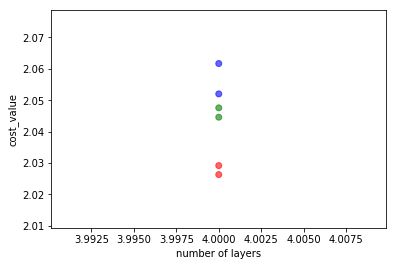

In [32]:
x_axis = [len(param_set['Layers']) for param_set in param_test]
y_axis = cost_list
def color(act):
    if act == TANH:
        return 'blue'
    if act == Sigmoid:
        return 'green'
    return 'red'
c = [color(param_set['Activations'][2]) for param_set in param_test]
plt.scatter(x_axis, y_axis, alpha=0.6,c=c)
plt.xlabel('number of layers')
plt.ylabel('cost_value')
plt.show()

From the two diagrams above, we find that Relu and SiLU tend to have similar behavior, and Relu has larger variance, this is because the derivative for Relu disappear when $x<0$, thus, if the epoch number is not large enough (heavily depends on the number of epochs), the result is not that good, but can be more accurate than SiLU when the train is long enough.

And it's clear from the second graph, ArcTan gives better result comparing to Sigmoid or TANH under same setting.

For the best set of parameters, we update SiLU with Relu.

In [34]:
best_param_idx = sorted(list(enumerate(cost_list)),key=lambda l:l[1])[0][0]
best_param = param_test[best_param_idx]
best_param

{'cost_function': 'quadratic',
 'Layers': [20, 20, 20, 3],
 'Activations': [__main__.Linear,
  __main__.Relu,
  __main__.ArcTan,
  __main__.Sigmoid]}

In [45]:
'''
best set of parameters, use such parameters to train for more epochs
'''
model = Sequential(C=0, epochs=4000, eta=0.000001, random_state=42, 
             cost_function=best_param['cost_function'], 
             metric='accuracy',
             verbose=1,
             regular='None',
             learning_rate=no_decay)
for neu_nbr, act in zip(best_param['Layers'],best_param['Activations']):
    model.add('Dense',neu_nbr)
    model.add('Activation',act)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
final_cost = find_cost_metric(y_test,y_pred,my_cost_matrix)
print(final_cost)

0 percent finished, current accuracy is 0.506.
10 percent finished, current accuracy is 0.595.
20 percent finished, current accuracy is 0.627.
30 percent finished, current accuracy is 0.643.
40 percent finished, current accuracy is 0.655.
50 percent finished, current accuracy is 0.664.
60 percent finished, current accuracy is 0.674.
70 percent finished, current accuracy is 0.682.
80 percent finished, current accuracy is 0.689.
90 percent finished, current accuracy is 0.693.
Training is done!
2.09746537758035


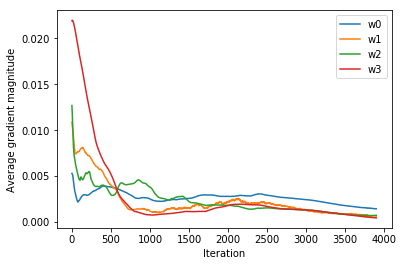

In [46]:
model.grad_plot()

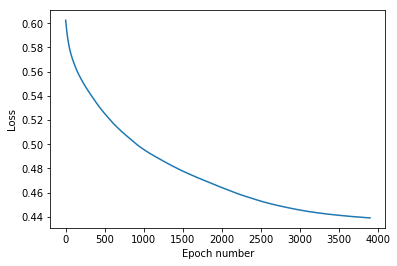

In [47]:
model.plot()

Notice that in our model the value of eta is very smaell, this is because we didnt compensate the partial derivative due to the large dateset.

In [ ]:
model = Sequential(C=0.1, epochs=10000, eta=0.001, random_state=42, 
                 cost_function='cross_entropy', 
                 metric='accuracy',
                 verbose=1,
                 regular='L1',
                 learning_rate=inverse_decay)
model.add('Dense',3)
model.add('Activation',Sigmoid)
model.add('Dense',20)
model.add('Activation',Sigmoid)
model.add('Dense',28)
model.add('Activation',Sigmoid)
model.add('Dense',3)
model.add('Activation',Sigmoid)

ds = load_iris()
X = ds.data
X_test = StandardScaler().fit(X).transform(X)
X = StandardScaler().fit(X).transform(X)
Y = ds.target # note problem is NOT binary anymore, there are three classes!


model.fit(X,Y)
#print(model.predict(X))
#print(Y)

In [ ]:
from sklearn.datasets import load_digits

ds = load_digits()
X = ds.data/16.0-0.5
Y = ds.target

model = Sequential(C=0.1, epochs=1000, eta=0.001, random_state=None, 
                 cost_function='cross_entropy', 
                 metric='accuracy',
                 verbose=1,
                 regular='L1',
                 learning_rate=no_decay)
model.add('Dense',60)
model.add('Activation',Sigmoid)
model.add('Dense',10)
model.add('Activation',Sigmoid)



model.fit(X,Y)
model.grad_plot()
print(model.predict(X))